# Deep RL and tennis or how to collaborating competing

### Reference:
 > [1] [Lillicrap, Hunt et al, Continous Control with Deep Reinforcement Learning, ICLR 2016](https://arxiv.org/pdf/1509.02971.pdf)  
 > [2] [Lowe et al, Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments](https://arxiv.org/pdf/1706.02275.pdf)

Load the relevant packages. Note that this notebook uses Unity environments.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import pickle

from IPython import display
%matplotlib inline

Set specific seeds for reproducibility

In [2]:
RANDOM_SEED = 2
np.random.seed(RANDOM_SEED)

Load the correct unity environment.

In [3]:
env = UnityEnvironment(file_name="./apps/Tennis", no_graphics=False, worker_id=1, seed=RANDOM_SEED)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. The next line checks for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.
The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.
Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.29742813 -1.5
 -0.          0.          7.17024279  6.         -0.          0.        ]


### A random agent

In [6]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

## Model

In [7]:
def hidden_init(layer):
    """Hidden layer's weights intialization"""
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=512, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=512, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, shape, seed, mu=0., theta=0.15, sigma=0.2): #sigma=.08):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(shape)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        #dx = self.theta * (self.mu - x) + self.sigma * (np.random.rand(*x.shape)-0.5)
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(x.shape)
        self.state = x + dx
        return self.state

    
    
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """ 
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""        
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        if len(self.memory) <= self.batch_size: return None

        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


## Agent

In all of our experiments, we use the Adam optimizer with a learning rate of 0.01 and τ = 0.01 for updating the target networks. γ is set to be 0.95. The size of the replay buffer is 1e6 and we update the network parameters after every 100 samples added to the replay buffer. We use a batch size of 1024 episodes before making an update, except for TRPO where we found a batch size of 50 lead to better performance (allowing it more updates relative to MADDPG). We train with 10 random seeds for environments with stark success/ fail conditions (cooperative communication, physical deception, and covert communication) and 3 random seeds for the other environments.

In [8]:
class Agent:
    
    def __init__(self, state_size, action_size, random_seed):   

        self.state_size = state_size        
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

#         # Critic Network (w/ Target Network)
#         self.critic_local = GLOBAL_CRITIC_LOCAL
#         self.critic_target = GLOBAL_CRITIC_TARGET                
#         self.critic_optimizer = GLOBAL_CRITIC_OPTIM

#         # Critic Network (w/ Target Network)
#         self.critic_local = Critic(state_size, action_size, random_seed).to(device)
#         self.critic_target = Critic(state_size, action_size, random_seed).to(device)
#         self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
                

        # Replay memory        
        self.memory = REPLAY_BUFFER

        # Noise process
        self.noise = NOISE
        
        self.t_step = 0
        
        # Actor and critic network losses
        self.critic_loss = []
        self.actor_loss  = []        
                
    def reset(self):
        self.t_step = 0
        self.noise.reset() 
   
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)

        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()        
        if add_noise:
            action += self.noise.sample().squeeze()
        return np.clip(action, -1, 1)
        
    def step_actor(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        self.memory.add(state, action, reward, next_state, done)
     
    def step_critic(self):
        # Learn, if enough samples are available in memory  
        experiences = self.memory.sample()        

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences)
                 
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.step_actor(state, action, reward, next_state, done)      
        self.step_critic()
#         self.memory.add(state, action, reward, next_state, done)
#         experiences = self.memory.sample()        
#         if not experiences: return
#         self.learn(experiences)

    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """    
        states, actions, rewards, next_states, dones = experiences
        
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        # Use the obtained action as input to the critic's network, along with the NEXT state
        Q_targets_next = GLOBAL_CRITIC_TARGET(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))        
        # Get the expected value from the critic's local network
        Q_expected = GLOBAL_CRITIC_LOCAL(states, actions)
        
        ## update critic network        
        # Compute critic loss
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        GLOBAL_CRITIC_OPTIM.zero_grad()
        critic_loss.backward()
        # torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        GLOBAL_CRITIC_OPTIM.step()

        ## update actor network
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -GLOBAL_CRITIC_LOCAL(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(GLOBAL_CRITIC_LOCAL, GLOBAL_CRITIC_TARGET, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        
        self.critic_loss.append(critic_loss)
        self.actor_loss.append(actor_loss)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Training

In [9]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 2e-1              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The task is episodic, and in order to solve the environment, the agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents). 
Specifically, after each episode, the rewards that each agent received 
(without discounting) are added up, to get a score for each agent. 
The maximum between these two, potentially different, scores is taken as single score for the episode. 
The environment is considered solved, when the average (over 100 episodes) of those scores is at least +0.5.

In [15]:
def ddpg(n_episodes=1000, ax=None):
    scores_deque = deque(maxlen=100)                          # A queue to keep only the last 100 episodes' scores
    
    for i_episode in range(1, n_episodes+1):
            
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment   
        
        states = env_info.vector_observations                 # get the current state (for each agent)
        scores = np.zeros(num_agents)                         # initialize the score (for each agent)
                                
        agent_0.reset()                    # Reset the agent to start the episode        
        agent_1.reset() 
        
        actions = np.zeros((num_agents, action_size))
        while True:  
            action_0 = agent_0.act(states[0], add_noise=True)
            action_1 = agent_1.act(states[1], add_noise=True)        
            actions = np.concatenate((action_0, action_1))              
                        
            env_info    = env.step(actions)[brain_name]       # send all actions to the environment
            next_states = env_info.vector_observations        # get next state (for each agent)
            rewards     = env_info.rewards                    # get reward (for each agent)
            dones       = env_info.local_done                 # see if episode finished
            scores      += rewards                            # update the score (for each agent). After each episode, we add up the rewards that each agent received (without discounting)
            
            # Perform an agent step. 
            agent_0.step_actor(states[0], action_0, rewards[0], next_states[0], dones[0])
            agent_1.step_actor(states[1], action_1, rewards[1], next_states[1], dones[1])
            
            agent_0.step_critic()
            agent_1.step_critic()
            
            states = next_states                              # Roll over states to next time step

            if np.any(dones):                                 # exit loop if episode finished
                break
                                      
        max_score = scores.max()                            # Get the max score of the episode (over all agents)
        scores_deque.append(max_score)                      # Store the score in the queue
        avg_score = np.mean(scores_deque)                   # Compute the mean score over the last 100 episodes
         
        if ax is not None:
            if max_score != 0:
                ax.scatter(i_episode, max_score, color='r', s=10) 
            ax.scatter(i_episode, avg_score, color='g', s=10)
            ax.set_ylabel('Score')
            ax.set_xlabel('Episode #')
            display.clear_output(wait=True)
            display.display(plt.gcf())
        else:
            print('\rEpisode: \t{} \tScore: \t{:.2f} \tMax Score: \t{:.2f} \tAverage Score: \t{:.2f}'.format(i_episode, max_score, np.max(scores_deque), np.mean(scores_deque)), end="") 

            
        if len(scores_deque) >= 100 and avg_score >= 0.5 :
            print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(i_episode, avg_score))
            torch.save(agent_0.actor_local.state_dict(), f'checkpoint-actor_local-agent-{0}.pth')
            torch.save(agent_0.actor_target.state_dict(), f'checkpoint-actor_target-agent-{0}.pth') 
            torch.save(agent_1.actor_local.state_dict(), f'checkpoint-actor_local-agent-{1}.pth')
            torch.save(agent_1.actor_target.state_dict(), f'checkpoint-actor_target-agent-{1}.pth') 
            torch.save(GLOBAL_CRITIC_LOCAL.state_dict(), f'checkpoint-global-critic_local.pth')
            torch.save(GLOBAL_CRITIC_TARGET.state_dict(), f'checkpoint-global-critic_target.pth') 

            with open('scores_deque.pkl', 'wb') as f:
                pickle.dump(scores_deque, f)
                
            break
         
        with open('./quit', 'r') as f:
            quit = int(f.readline())
            if quit == 1:
                print('QUIT')
                break
            
    return scores_deque

In [16]:
REPLAY_BUFFER = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, RANDOM_SEED)
NOISE = OUNoise(action_size, RANDOM_SEED)
#NOISE = OUNoise((num_agents, action_size), RANDOM_SEED)

GLOBAL_CRITIC_LOCAL  = Critic(state_size, action_size, RANDOM_SEED).to(device)
GLOBAL_CRITIC_TARGET = Critic(state_size, action_size, RANDOM_SEED).to(device)
GLOBAL_CRITIC_OPTIM  = optim.Adam(GLOBAL_CRITIC_LOCAL.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

agent_0 = Agent(state_size, action_size, RANDOM_SEED)
agent_1 = Agent(state_size, action_size, RANDOM_SEED) 

In [17]:
!echo '0' > ./quit

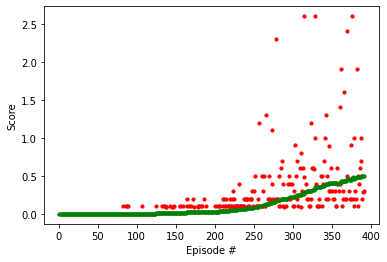

Environment solved in 391 episodes, average score: 0.50


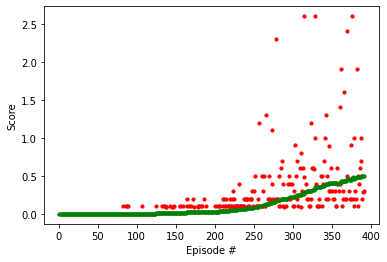

In [18]:
fig = plt.figure();
scores = ddpg(n_episodes=1000, ax=fig.add_subplot(111));     

### Analysing the last 100 episodes

In [57]:
with open('saved-mdls/scores_deque.pkl', 'rb') as f:
    my_scores = pickle.load(f)

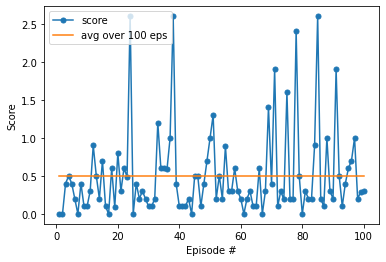

In [82]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(my_scores)+1), my_scores, marker='.', markersize=10)
plt.plot(np.arange(1, len(my_scores)+1), np.ones(len(my_scores))*np.mean(my_scores))
plt.ylabel('Score')
plt.xlabel('Episode #')
ax.legend(['score', 'avg over 100 eps'])
plt.show()

## Plot actor and critic loss

Text(0.5, 1.0, 'Agent 1, Critic loss')

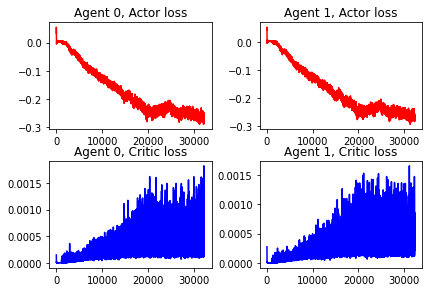

In [33]:
# Creates two subplots 
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, sharey=False)
f.tight_layout()

ax1[0].plot(agent_0.actor_loss, color='r')
ax1[0].set_title('Agent 0, Actor loss')

ax2[0].plot(agent_0.critic_loss, color='b')
ax2[0].set_title('Agent 0, Critic loss')


ax1[1].plot(agent_1.actor_loss, color='r')
ax1[1].set_title('Agent 1, Actor loss')

ax2[1].plot(agent_1.critic_loss, color='b')
ax2[1].set_title('Agent 1, Critic loss')

### Test it

Load the network weights and play. Note that now we only use the Actor network.

In [50]:
my_agent_0 = Agent(state_size, action_size, RANDOM_SEED)
my_agent_1 = Agent(state_size, action_size, RANDOM_SEED) 

my_agent_0.actor_local.load_state_dict(torch.load('./saved-mdls/checkpoint-actor_local-agent-0.pth', map_location=lambda storage, loc: storage))
my_agent_0.actor_local.eval()

my_agent_1.actor_local.load_state_dict(torch.load('./saved-mdls/checkpoint-actor_local-agent-1.pth', map_location=lambda storage, loc: storage))
my_agent_1.actor_local.eval();

In [52]:
for i in range(1):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        action_0 = my_agent_0.act(states[0], add_noise=False)
        action_1 = my_agent_1.act(states[1], add_noise=False)        
        actions = np.concatenate((action_0, action_1))              

        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 0: 2.600000038743019


Close the environment

In [83]:
env.close()